In [1]:
import os
import math
import torch
import torchvision
import numpy as np
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import DataLoader
from flow_matching.path import CondOTProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper


In [2]:
torch.cuda.empty_cache()

In [ ]:
def get_sinusoidal_positional_embedding(t, embedding_dim):
    """
    Create sinusoidal embedding of scalar t.
 
    Args:
        t: tensor of shape [B] or [B,1], values in [0,1]
        embedding_dim: size of the output embedding
 
    Returns:
        A tensor of shape [B, embedding_dim].
    """
    if t.dim() == 1:
        t = t.unsqueeze(1)  # [B, 1]
    half_dim = embedding_dim // 2
    # Exponential decay frequencies
    freq = torch.exp(
        torch.linspace(
            0, math.log(10000), half_dim, device=t.device
        )
    )
    # shape: [half_dim]
    # Outer product -> (B, half_dim)
    args = t * freq.unsqueeze(0)
 
    sin = torch.sin(args)
    cos = torch.cos(args)
    emb = torch.cat([sin, cos], dim=1)  # (B, embedding_dim)
    return emb
 
class TimeLabelEmbedding(nn.Module):
    """
    Combines a sinusoidal time embedding and a label embedding, 
    then processes them with an MLP.
    """
    def __init__(self, num_classes, embedding_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        # Label embedding
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        # A small MLP to merge time emb + label emb
        self.mlp = nn.Sequential(
            nn.Linear(2 * embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
 
    def forward(self, t, y):
        """
        t: (B,) or (B,1) time steps in [0,1]
        y: (B,) class labels
        """
        # Sinusoidal time emb
        time_emb = get_sinusoidal_positional_embedding(t, self.embedding_dim)
        # Label emb
        label_emb = self.label_emb(y)  # [B, embedding_dim]
        # Concatenate
        combined = torch.cat([time_emb, label_emb], dim=1)  # (B, 2*embedding_dim)
        # MLP
        cond = self.mlp(combined)  # (B, embedding_dim)
        return cond
 
class DoubleConv(nn.Module):
    """
    Double 3x3 conv layers with conditioning-based FiLM.
 
    in_channels -> out_channels,
    using two (Conv -> BN -> ReLU) in sequence.
    """
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
 
        self.act = nn.ReLU(inplace=True)
 
        # For FiLM parameters (scale + shift) from the embedding
        self.scale_shift1 = nn.Linear(emb_dim, 2 * out_channels)  # gamma1, beta1
        self.scale_shift2 = nn.Linear(emb_dim, 2 * out_channels)  # gamma2, beta2
 
    def forward(self, x, emb):
        """
        x: (B, in_channels, H, W)
        emb: (B, emb_dim)
        """
        # ----- First Conv -----
        x = self.conv1(x)
        x = self.bn1(x)
 
        # Get gamma,beta from embedding for the first conv
        gamma1, beta1 = self.scale_shift1(emb).chunk(2, dim=1)  # each (B, out_channels)
        # Reshape/broadcast to (B, out_channels, 1, 1)
        gamma1 = gamma1.unsqueeze(-1).unsqueeze(-1)
        beta1 = beta1.unsqueeze(-1).unsqueeze(-1)
 
        # FiLM: x = x * (1 + gamma) + beta
        x = x * (1 + gamma1) + beta1
        x = self.act(x)
 
        # ----- Second Conv -----
        x = self.conv2(x)
        x = self.bn2(x)
 
        # Get gamma,beta from embedding for the second conv
        gamma2, beta2 = self.scale_shift2(emb).chunk(2, dim=1)
        gamma2 = gamma2.unsqueeze(-1).unsqueeze(-1)
        beta2 = beta2.unsqueeze(-1).unsqueeze(-1)
 
        x = x * (1 + gamma2) + beta2
        x = self.act(x)
        return x
 
class Down(nn.Module):
    """
    Downscale by factor of 2 (MaxPool) then DoubleConv with conditioning.
    """
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv = DoubleConv(in_channels, out_channels, emb_dim)
 
    def forward(self, x, emb):
        x = self.pool(x)
        x = self.conv(x, emb)
        return x
 
 
class Up(nn.Module):
    """
    Upscale by factor of 2 (ConvTranspose2d), then concat the skip connection,
    then DoubleConv with conditioning.
    """
    def __init__(self, in_channels, out_channels, emb_dim, bilinear=False):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
            )
        else:
            # Classic transposed conv
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
 
        self.conv = DoubleConv(2 * out_channels, out_channels, emb_dim)
 
    def forward(self, x1, x2, emb):
        """
        x1: the 'lower' resolution feature
        x2: the skip-connection feature from earlier in the encoder
        emb: the conditioning embedding
        """
        x1 = self.up(x1)
 
        # Handle any dimension mismatches (odd input sizes)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        if diffY != 0 or diffX != 0:
            x1 = nn.functional.pad(
                x1, 
                [diffX // 2, diffX - diffX // 2,
                 diffY // 2, diffY - diffY // 2]
            )
 
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x, emb)
        return x
 
class OutConv(nn.Module):
    """
    Final 1x1 convolution to get the desired output channels.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
 
    def forward(self, x):
        x = self.conv(x)
        return x
 
class UNetCond(nn.Module):
    """
    U-Net that accepts:
      - x: the input image/tensor
      - t: a scalar time in [0,1] (for diffusion steps, etc.)
      - y: a class label for conditional generation
 
    Channels double as we go down, then halve as we go up, 
    with FiLM-like conditioning in each block based on (t,y).
    """
    def __init__(
        self,
        num_classes=10,
        in_channels=3,
        out_channels=3,
        base_channels=64,
        emb_dim=128,
        bilinear=False
    ):
        super().__init__()
        # For time + label conditioning
        self.time_label_emb = TimeLabelEmbedding(num_classes, embedding_dim=emb_dim)
 
        # Encoder/down
        self.inc = DoubleConv(in_channels, base_channels, emb_dim)
        self.down1 = Down(base_channels, base_channels * 2, emb_dim)
        self.down2 = Down(base_channels * 2, base_channels * 4, emb_dim)
        self.down3 = Down(base_channels * 4, base_channels * 8, emb_dim)
 
        factor = 2 if bilinear else 1
        self.down4 = Down(base_channels * 8, base_channels * 16 // factor, emb_dim)
 
        # Decoder/up
        self.up1 = Up(base_channels * 16, base_channels * 8 // factor, emb_dim, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 4 // factor, emb_dim, bilinear)
        self.up3 = Up(base_channels * 4, base_channels * 2 // factor, emb_dim, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, emb_dim, bilinear)
        self.outc = OutConv(base_channels, out_channels)
 
    def forward(self, x, t, y):
        """
        x: (B, in_channels, H, W)
        t: (B,) or (B,1) time in [0,1]
        y: (B,) class labels
        """
        # 1) Get combined time+label embedding
        emb = self.time_label_emb(t, y)  # (B, emb_dim)
 
        # 2) Encoder
        x1 = self.inc(x, emb)
        x2 = self.down1(x1, emb)
        x3 = self.down2(x2, emb)
        x4 = self.down3(x3, emb)
        x5 = self.down4(x4, emb)
 
        # 3) Decoder
        x = self.up1(x5, x4, emb)
        x = self.up2(x, x3, emb)
        x = self.up3(x, x2, emb)
        x = self.up4(x, x1, emb)
 
        # 4) Final output
        logits = self.outc(x)
        return logits

In [4]:
train_dataset_cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

In [5]:
train_dataset_celeba = torchvision.datasets.CelebA(root="./data", split="all", download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

In [6]:
def conditional_flow_matching_loss(flow_model, x, y, path):
    x_0 = torch.randn_like(x).cuda()
 
    t = torch.rand(x.shape[0]).to("cuda")
 
    path_sample = path.sample(t = t, x_0=x_0, x_1=x)
 
    optimal_flow = path_sample.dx_t
    predicted_flow = flow_model(path_sample.x_t, path_sample.t, y)
 
    return (predicted_flow - optimal_flow).square().mean()

In [7]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, y):
        return self.model(x, torch.full(x.shape[:1], fill_value=t, device="cuda"), y.to("cuda"))
 
@torch.no_grad()
def run_flow_discrete(flow_model, starting_point, t_initial, t_final, labels, device="cuda"):
    solver = ODESolver(flow_model)
    times = torch.linspace(t_initial, t_final, 10)
    return solver.sample(x_init = starting_point, method="euler", time_grid=times, step_size=0.1, y=labels)

In [8]:
data_type = "celeba"
checkpoint_path = ""

In [9]:
if data_type == "cifar":
    num_epochs = 10000
    lr = 5e-3
    batch_size = 768
    loader_num_workers = 2
    eval_and_checkpoint_every=50
else:
    num_epochs = 16
    lr = 5e-3
    batch_size = 20
    loader_num_workers = 2
    eval_and_checkpoint_every=1

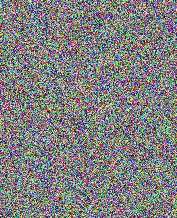

In [10]:
model = UNetCond(num_classes=10 if data_type == "cifar" else 2, in_channels=3, out_channels=3, base_channels=64, emb_dim=128, bilinear=False)

if checkpoint_path:
    model.load_state_dict(torch.load(checkpoint_path))

path = CondOTProbPath()

wrapped_model = WrappedModel(model).cuda()
wrapped_model.eval()

size = [1,3,32,32] if data_type == "cifar" else [1,3,218,177]
random_label = random.randint(0, 9) if data_type == "cifar" else random.randint(0,1)

output = run_flow_discrete(wrapped_model, torch.randn(size).cuda(), 0, 1, torch.tensor([random_label]).cuda())
image_array = output.squeeze(0).permute(1,2,0).cpu().numpy()
image = Image.fromarray((image_array * 255).astype(np.uint8))
 
display(image)

In [11]:
def convert_label_to_gender_label(target):
    """Convert gender label to 1 for women and 0 for men."""
    return torch.tensor(1) if target[20].item() == -1 else torch.tensor(0)

def collate_by_gender(batch):
    images, targets = zip(*batch)
    transformed_targets = [convert_label_to_gender_label(target) for target in targets]
    return torch.stack(images), torch.stack(transformed_targets)

In [12]:
if data_type == "cifar":
    train_loader = DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True, num_workers=loader_num_workers)
else:
    train_loader = DataLoader(train_dataset_celeba, batch_size=batch_size, shuffle=True, num_workers=loader_num_workers, collate_fn=collate_by_gender)

Epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=1_loss=0.055405.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=1_loss=0.055405.ckpt


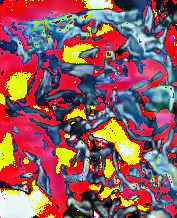

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=2_loss=0.053339.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=2_loss=0.053339.ckpt


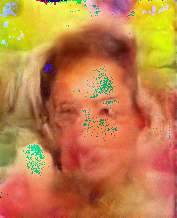

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=3_loss=0.027821.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=3_loss=0.027821.ckpt


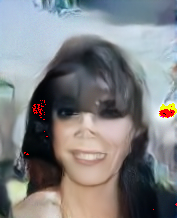

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=4_loss=0.037457.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=4_loss=0.037457.ckpt


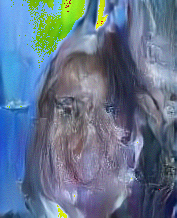

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=5_loss=0.027304.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=5_loss=0.027304.ckpt


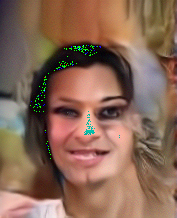

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=6_loss=0.078726.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=6_loss=0.078726.ckpt


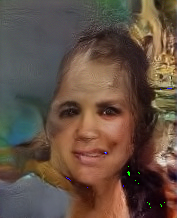

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=7_loss=0.084844.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=7_loss=0.084844.ckpt


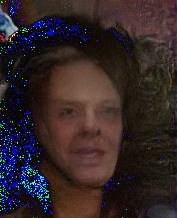

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=8_loss=0.051575.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=8_loss=0.051575.ckpt


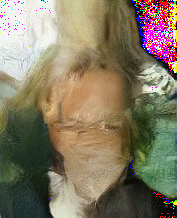

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=9_loss=0.050074.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=9_loss=0.050074.ckpt


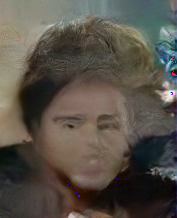

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=10_loss=0.040507.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=10_loss=0.040507.ckpt


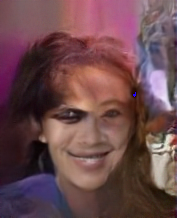

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=11_loss=0.027991.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=11_loss=0.027991.ckpt


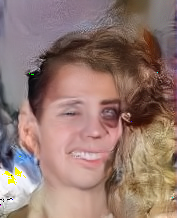

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=12_loss=0.021614.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=12_loss=0.021614.ckpt


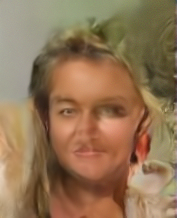

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=13_loss=0.027888.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=13_loss=0.027888.ckpt


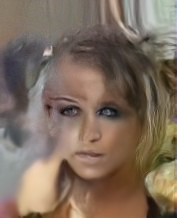

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=14_loss=0.053226.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=14_loss=0.053226.ckpt


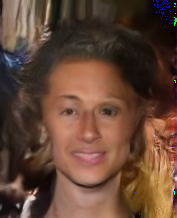

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=15_loss=0.027554.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=15_loss=0.027554.ckpt


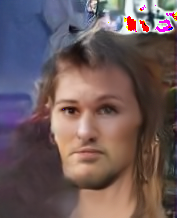

Batch:   0%|          | 0/10130 [00:00<?, ?it/s]

Saving ./checkpoints/celeba_1743533882/epoch=16_loss=0.029548.ckpt
Evaluating model at checkpoint ./checkpoints/celeba_1743533882/epoch=16_loss=0.029548.ckpt


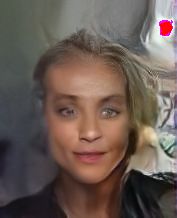

In [13]:
checkpoints_base_name = f"{data_type}_{time.time():.0f}"

model.cuda()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=16)
amount_batches = len(train_loader)


epoch_progress_bar = tqdm(total=num_epochs, desc="Epoch", leave=True)

for epoch in range(num_epochs):

    batch_progress_bar = tqdm(total=amount_batches, desc="Batch", leave=True)
    for batch_index, (images, labels) in enumerate(train_loader):
        model.zero_grad()
        loss = conditional_flow_matching_loss(model, images.cuda(), labels.cuda(), path)           
        if torch.isnan(loss):
            print("loss reached NaN. Early stopping.")
            raise ValueError("loss reached NaN")
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        batch_progress_bar.update(1)

    scheduler.step()
    batch_progress_bar.close()
    epoch_progress_bar.set_description(f"Epoch (Loss = {loss.item():.6f})")
    epoch_progress_bar.update(1)
    
    if (epoch + 1) % eval_and_checkpoint_every == 0 or (epoch + 1) == num_epochs:
        checkpoint_directory = f"./checkpoints/{checkpoints_base_name}"
        checkpoint_name = f"{checkpoint_directory}/epoch={epoch+1}_loss={loss.item():.6f}.ckpt"
        print(f"Saving {checkpoint_name}")
        os.makedirs(checkpoint_directory, exist_ok=True)
        torch.save(model.state_dict(), checkpoint_name)

        print(f"Evaluating model at checkpoint {checkpoint_name}")
        model.eval()
        wrapped_model = WrappedModel(model)
        wrapped_model.eval()

        size = [1,3,32,32] if data_type == "cifar" else [1,3,218,177]
        random_label = random.randint(0, 9) if data_type == "cifar" else random.randint(0,1)
        output = run_flow_discrete(wrapped_model, torch.randn(size).cuda(), 0, 1, torch.tensor([random_label]).cuda()) 
        image_array = output.squeeze(0).permute(1,2,0).cpu().numpy()
        image = Image.fromarray((image_array * 255).astype(np.uint8))
        display(image)

        model.train()

batch_progress_bar.close()
        